In [115]:
import sys 
import os
from building_physics import Zone
import numpy as np
import pandas as pd 
import supply_system
import emission_system
import matplotlib.pyplot as plt
from radiation import Location, Window

### Restrictions: 
- hourly resolution, lässt sich aber bestimmt ändern mit passenden Daten 
- Nimmt an SupplyAir = OutsideAir 
- Nur ein Raum bisher, mehrere unabhängige Räume simpel, zusammenhängende Räume nicht trivial umzusetzen

In [116]:
START_HEATING = 16
START_COOLING = 25

USE_CUSTOM_HVAC = True

if USE_CUSTOM_HVAC:
    heating_sup_system = supply_system.HeatPumpCustom
    cooling_sup_system = supply_system.HeatPumpCustom
else:
    heating_sup_system = supply_system.HeatPumpAir
    cooling_sup_system = supply_system.HeatPumpAir

In [117]:
# TODO finde .epw und occupation Datei für passende Region, erhöhe sampling rate auf 15 min

In [ ]:
Zurich = Location(epwfile_path='./auxiliary/Zurich-Kloten_2013.epw')

Office = Zone(window_area=4.0,
              walls_area=11.0,
              floor_area=35.0,
              room_vol=105,
              total_internal_area=142.0,
              lighting_load=11.7,
              lighting_control=300.0,
              lighting_utilisation_factor=0.45,
              lighting_maintenance_factor=0.9,
              u_walls=0.2,
              u_windows=1.1,
              ach_vent=1.5,
              ach_infl=0.5,
              ventilation_efficiency=0.6,
              thermal_capacitance_per_floor_area=165000,
              t_set_heating=START_HEATING,
              t_set_cooling=START_COOLING,
              max_cooling_energy_per_floor_area=-np.inf,
              max_heating_energy_per_floor_area=np.inf,
              heating_supply_system=heating_sup_system,
              cooling_supply_system=cooling_sup_system,
              heating_emission_system=emission_system.NewRadiators,
              cooling_emission_system=emission_system.AirConditioning,)
                     

SouthWindow = Window(azimuth_tilt=0, alititude_tilt=90, glass_solar_transmittance=0.7,
                     glass_light_transmittance=0.8, area=4)

assert(SouthWindow.area == Office.window_area)

# Define constants for the Zone
gain_per_person = 100  # W per person
appliance_gains = 14  # W per sqm
max_occupancy = 3.0


# Read Occupancy Profile
occupancyProfile = pd.read_csv('./auxiliary/schedules_el_OFFICE.csv')

In [119]:
# Empty Lists for Storing Data to Plot
ElectricityOut = []
HeatingDemand = []  # Energy required by the zone
HeatingEnergy = []  # Energy required by the supply system to provide HeatingDemand
CoolingDemand = []  # Energy surplus of the zone
CoolingEnergy = []  # Energy required by the supply system to get rid of CoolingDemand
IndoorAir = []
OutsideTemp = []
SolarGains = []
COP = []


In [120]:

for hour in range(8760):

    # Occupancy for the time step
    occupancy = occupancyProfile.loc[hour, 'People'] * max_occupancy
    # Gains from occupancy and appliances
    internal_gains = occupancy * gain_per_person + \
        appliance_gains * Office.floor_area

    # Extract the outdoor temperature in Zurich for that hour
    t_out = Zurich.weather_data['drybulb_C'][hour]

    Altitude, Azimuth = Zurich.calc_sun_position(
        latitude_deg=47.480, longitude_deg=8.536, year=2015, hoy=hour)

    SouthWindow.calc_solar_gains(sun_altitude=Altitude, sun_azimuth=Azimuth,
                                 normal_direct_radiation=Zurich.weather_data[
                                     'dirnorrad_Whm2'][hour],
                                 horizontal_diffuse_radiation=Zurich.weather_data['difhorrad_Whm2'][hour])


    Office.solve_energy(internal_gains=internal_gains,
                        solar_gains=SouthWindow.solar_gains,
                        t_out=t_out,
                        t_m_prev=t_m_prev)


    # Set the previous temperature for the next time step
    t_m_prev = Office.t_m_next

    HeatingDemand.append(Office.heating_demand)
    HeatingEnergy.append(Office.heating_energy)
    CoolingDemand.append(Office.cooling_demand)
    CoolingEnergy.append(Office.cooling_energy)
    ElectricityOut.append(Office.electricity_out)
    IndoorAir.append(Office.t_air)
    OutsideTemp.append(t_out)
    SolarGains.append(SouthWindow.solar_gains)
    COP.append(Office.cop)

annualResults = pd.DataFrame({
    'HeatingDemand': HeatingDemand,
    'HeatingEnergy': HeatingEnergy,
    'CoolingDemand': CoolingDemand,
    'CoolingEnergy': CoolingEnergy,
    'IndoorAir': IndoorAir,
    'OutsideTemp':  OutsideTemp,
    'SolarGains': SolarGains,
    'COP': COP
})




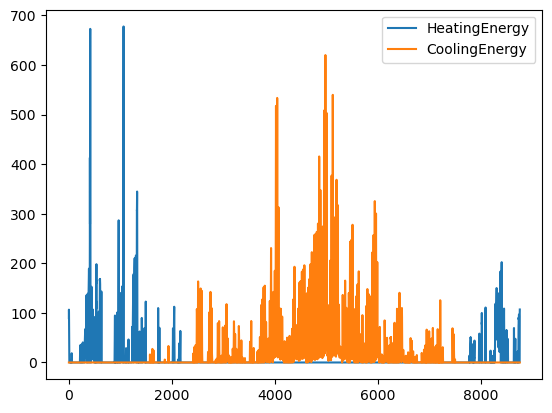

In [121]:
annualResults[['HeatingEnergy', 'CoolingEnergy']].plot()

plt.show()


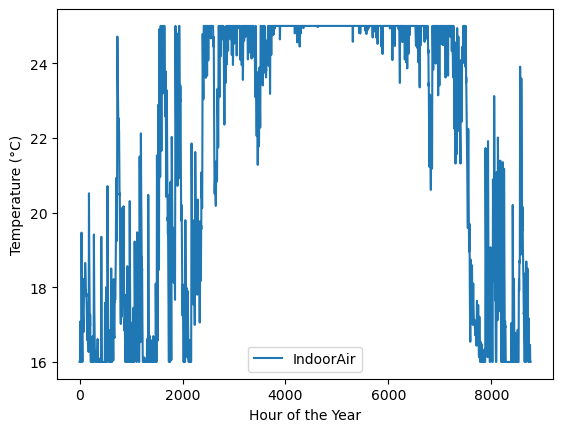

In [122]:
annualResults[["IndoorAir"]].plot()
plt.xlabel('Hour of the Year')
plt.ylabel('Temperature (°C)')
plt.show()

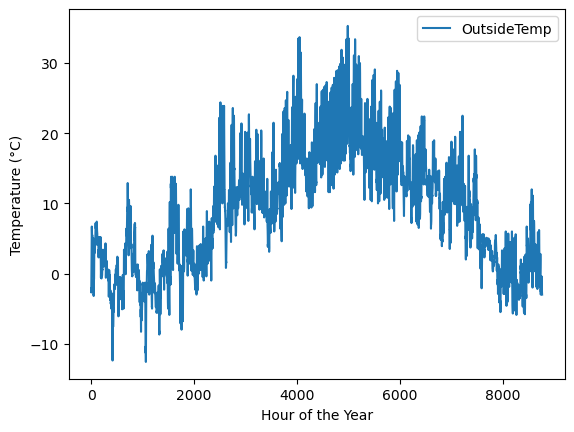

In [123]:
annualResults[["OutsideTemp"]].plot()
plt.xlabel('Hour of the Year')
plt.ylabel('Temperature (°C)')
plt.show()

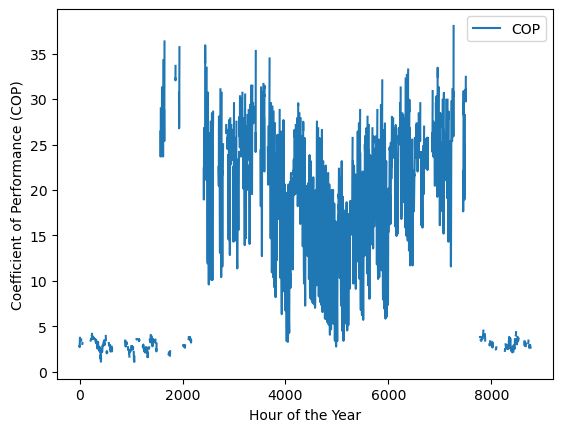

In [124]:
#plot cop over time
annualResults[["COP"]].plot()
plt.xlabel('Hour of the Year')
plt.ylabel('Coefficient of Performance (COP)')
plt.show()

In [125]:
Office = Zone()  
t_m_prev = Zurich.weather_data['drybulb_C'][0]

IndoorAir, Tm, Ts = [], [], []

for hour in range(8760):
    occupancy = occupancyProfile.loc[hour, 'People'] * max_occupancy
    internal_gains = occupancy * gain_per_person + appliance_gains * Office.floor_area
    t_out = Zurich.weather_data['drybulb_C'][hour]
    Altitude, Azimuth = Zurich.calc_sun_position(latitude_deg=47.480, longitude_deg=8.536, year=2015, hoy=hour)

    SouthWindow.calc_solar_gains(
        sun_altitude=Altitude,
        sun_azimuth=Azimuth,
        normal_direct_radiation=Zurich.weather_data['dirnorrad_Whm2'][hour],
        horizontal_diffuse_radiation=Zurich.weather_data['difhorrad_Whm2'][hour]
    )

    Office.calc_temperatures_crank_nicolson(
        energy_demand=0.0,
        internal_gains=internal_gains,
        solar_gains=SouthWindow.solar_gains,
        t_out=t_out,
        t_m_prev=t_m_prev
    )

    t_m_prev = Office.t_m_next

    IndoorAir.append(Office.t_air)
    Tm.append(Office.t_m)
    Ts.append(Office.t_s)

free_run = pd.DataFrame({
    'T_air_no_HVAC': IndoorAir,
    'T_mass_avg': Tm,
    'T_surface': Ts
}, index=pd.RangeIndex(8760, name='hour'))


In [126]:
#extend dataframe with outdoor temperature for comparison
free_run["OutsideTemp"] = annualResults["OutsideTemp"]

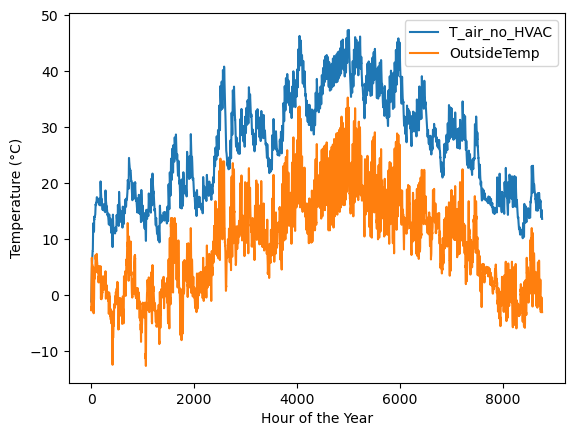

In [127]:
#plot t air
free_run[['T_air_no_HVAC', 'OutsideTemp']].plot()
plt.xlabel('Hour of the Year')
plt.ylabel('Temperature (°C)')
plt.show()